In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from energy_consumption.help_functions import get_energy_data, dummy_mapping, get_forecast_timestamps, create_submission_frame

In [2]:
energydata = get_energy_data.get_data()

# create dummies for season and day in the week
energydata = dummy_mapping.get_season_mapping(energydata)
energydata = dummy_mapping.get_day_mapping(energydata)

100%|██████████| 102/102 [01:06<00:00,  1.54it/s]


### Map hours 
* to 3 different classes within the day
* find best classes through unsupervised learning
* for unsupervised learning algo, delete "outliers"


1. Impute missing data and create desired frame

In [3]:
from datetime import datetime
ec = energydata[['energy_consumption']]
ec['hour'] = ec.index.hour
ec['date'] = ec.index.date

e_per_hour = ec.pivot(
    index='date', columns='hour', values='energy_consumption')

# Rename the columns to indicate the hour with "ec_h"
e_per_hour.columns = [f'ec{hour}' for hour in e_per_hour.columns]

# impute missing data of last row by last weeks ec (7 days ahead)
# ! iloc index needs to be changed to -7 after 12am
nan_columns = e_per_hour.columns[e_per_hour.iloc[-1].isna()]
imputation_values = e_per_hour.iloc[-8,:].loc[nan_columns]           

# Replace NaN values in the last row with corresponding imputation values
e_per_hour.loc[e_per_hour.index[-1], nan_columns] = imputation_values


Text(0, 0.5, 'Energy Consumption [GwH]')

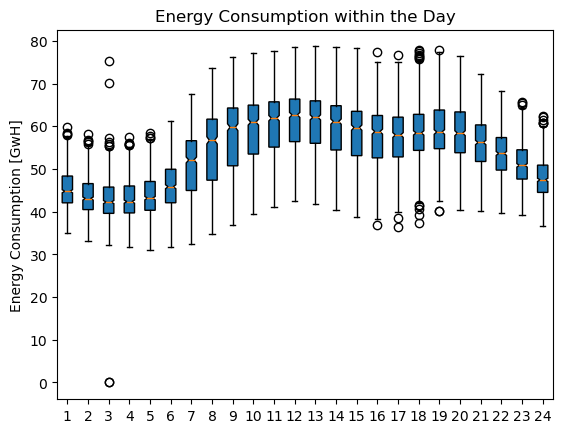

In [4]:
energy_array = np.array(e_per_hour)
plt.boxplot(energy_array, patch_artist=True, notch=True)
plt.title('Energy Consumption within the Day')
plt.ylabel("Energy Consumption [GwH]")

#Auffällig: Outlier

Found outliers --> delete them <br>
*Note*: Outliers follow a pattern --> consider later

In [5]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(e_per_hour)

# Get the outlier scores 
X_scores = clf.negative_outlier_factor_

# Find the indices of the rows with the biggest outliers 
top_outliers_indices = X_scores.argsort()[:10]

# Get the rows with the biggest outliers
top_outliers_rows = e_per_hour.iloc[top_outliers_indices]

# Display the rows with the biggest outliers
print("Rows with the biggest outliers:")
print(top_outliers_rows.loc[:,'ec2'])

print("\nOutlier scores:")
print(X_scores[top_outliers_indices])

Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\Maria\Documents\Setups\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\Maria\Documents\Setups\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Maria\Documents\Setups\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 3: invalid start byte
c:\Users\Maria\Documents\Setups\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Maria\Documents\Setups\L

Rows with the biggest outliers:
date
2023-03-26     0.00000
2022-03-27     0.00000
2022-10-30    70.08650
2023-10-29    75.39100
2023-10-25    43.92925
2023-05-28    32.49825
2023-04-09    35.29025
2021-12-27    44.00350
2022-01-29    51.81875
2021-12-28    45.09350
Name: ec2, dtype: float64

Outlier scores:
[-4.91546367 -4.45608734 -4.1746579  -3.90514395 -2.28462298 -2.12156008
 -1.87179731 -1.84939813 -1.79033727 -1.78776978]


Found four significant outliers --> delete these days 

ec0     45.367078
ec1     43.737543
ec2     42.880657
ec3     42.923559
ec4     43.753076
ec5     45.987478
ec6     50.922918
ec7     55.080540
ec8     58.015130
ec9     59.479860
ec10    60.610525
ec11    61.548574
ec12    61.187594
ec13    59.966964
ec14    58.592605
ec15    57.784644
ec16    57.393788
ec17    58.345161
ec18    58.908908
ec19    58.351379
ec20    56.063820
ec21    53.598744
ec22    51.151193
ec23    47.924487
dtype: float64

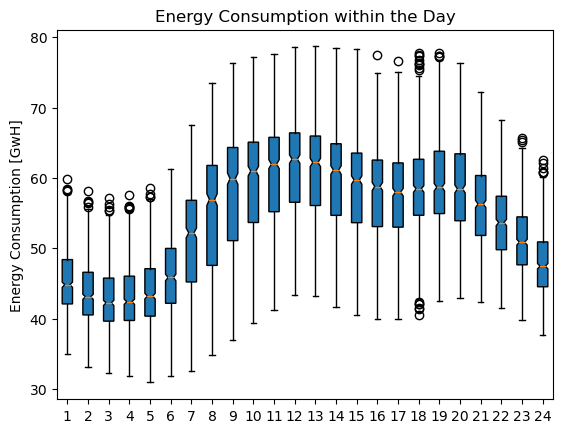

In [6]:
# Delete the rows with the biggest outliers from the original DataFrame
e_per_hour_filtered = e_per_hour.drop(e_per_hour.index[top_outliers_indices])

# plot boxplot with filtered data
energy_array_filtered = np.array(e_per_hour_filtered)
plt.boxplot(energy_array_filtered, patch_artist=True, notch=True)
plt.title('Energy Consumption within the Day')
plt.ylabel("Energy Consumption [GwH]")

e_per_hour_filtered.mean()

### Find time mappings 

1. Approach: Based on means and intervals of fixed length (current basis for seasonal_QR model)

In [185]:
column_means = e_per_hour_filtered.mean()
means_array = np.array(column_means)

max_mean = means_array.max()
min_mean = means_array.min()
interval_length = (max_mean-min_mean)/4

intervals = [min_mean+interval_length, 
     min_mean +2*interval_length, 
     min_mean+3*interval_length, 
     max_mean]

hour_mapping = {
    'lc': [],  # low consumption: between i[0] and i[1] 
    'mc': [],  # medium consumption: between i[1] and i[2]
    'hc': []   # high consumption: between i[2] and i[3]
}

for i in range(len(means_array)):

    col = str('ec' + str(i))
    col_mean = means_array[i]

    # low consumption
    if (col_mean > intervals[0]) & (col_mean <= intervals[1]):
        hour_mapping['lc'].append(col)
    elif (col_mean > intervals[1]) & (col_mean <= intervals[2]):
        hour_mapping['mc'].append(col)
    elif (col_mean > intervals[2]) & (col_mean <= intervals[3]):
        hour_mapping['hc'].append(col)
    else:
        print(col + ' in class of lowest consumption time')
    
hour_mapping 
# use this mappings
    

ec0 in class of lowest consumption time
ec1 in class of lowest consumption time
ec2 in class of lowest consumption time
ec3 in class of lowest consumption time
ec4 in class of lowest consumption time
ec5 in class of lowest consumption time


{'lc': ['ec6', 'ec22', 'ec23'],
 'mc': ['ec7', 'ec20', 'ec21'],
 'hc': ['ec8',
  'ec9',
  'ec10',
  'ec11',
  'ec12',
  'ec13',
  'ec14',
  'ec15',
  'ec16',
  'ec17',
  'ec18',
  'ec19']}

2. Approach: Clustering via K-means

In [37]:
from sklearn.cluster import KMeans

mean_df = pd.DataFrame(e_per_hour_filtered.mean())

kmeans = KMeans(n_clusters=8, max_iter=200, n_init="auto")
kmeans.fit(mean_df)

output = { 
    'hours': np.array([f'ec{h}' for h in range(24)]),
    'cluster': kmeans.predict(mean_df)
    }

kmeans_result = pd.DataFrame(output)
kmeans_result

c:\Users\Maria\Documents\Setups\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,hours,cluster
0,ec0,1
1,ec1,3
2,ec2,3
3,ec3,3
4,ec4,3
5,ec5,1
6,ec6,5
7,ec7,6
8,ec8,4
9,ec9,0
